In [2]:
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/Pynq-CV-OV5640-master')
from pynq import Overlay
from pynq.lib.iic import *
from ov5640.ov5640_config import ov5640_config
from pynq.lib.video import *
from time import sleep
from ov5640 import dma
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from scipy import ndimage
from IPython.display import display, clear_output
import time
%matplotlib inline

# 新增导入
import cv2
import json
import threading
import psutil
import gc
from datetime import datetime
import traceback
from enum import Enum

print("🎯 金属表面划痕检测系统 - 优化版初始化开始")
print("=" * 60)

class SystemState(Enum):
    NORMAL = "正常"
    DEGRADED = "降级"
    FAILED = "故障"
    INITIALIZING = "初始化中"

try:
    # 1. 加载比特流
    bitstream_path = "/home/xilinx/jupyter_notebooks/Pynq-CV-OV5640-master/boards/Pynq-Z2/ov5640/bitstream/cv_ov5640.bit"
    if not os.path.exists(bitstream_path):
        raise FileNotFoundError(f"比特流文件不存在: {bitstream_path}")
    
    cv_ov5640 = Overlay(bitstream_path)
    print("✅ 比特流加载成功")
    
    # 2. 检查必需IP核
    required_ips = ['axi_iic_0', 'axi_vdma_0', 'axi_vdma_1']
    for ip in required_ips:
        if ip not in cv_ov5640.ip_dict:
            raise RuntimeError(f"缺少IP核: {ip}")
    print("✅ 硬件IP核检查通过")
    
    # 3. 配置I2C和摄像头
    iic = AxiIIC(cv_ov5640.ip_dict['axi_iic_0'])
    address = 0x3c
    
    # 带重试的摄像头配置
    success_count = 0
    max_config_attempts = 3
    
    for attempt in range(max_config_attempts):
        try:
            for config in ov5640_config:
                tmp1 = config[0] >> 8
                tmp2 = config[0] & 0xff
                iic.send(address, bytes([tmp1, tmp2, config[1]]), 3)
                success_count += 1
            print(f"✅ 摄像头配置成功 ({success_count}个参数)")
            break
        except Exception as e:
            if attempt == max_config_attempts - 1:
                raise RuntimeError(f"摄像头配置失败: {e}")
            print(f"⚠️ 摄像头配置尝试 {attempt+1} 失败，重试...")
            sleep(1)
    
    # 4. 配置图像处理IP核（启用硬件加速）
    # 去马赛克
    bayer2rgb = cv_ov5640.v_demosaic_0
    bayer2rgb.write(0x10, 1280)
    bayer2rgb.write(0x18, 720)
    bayer2rgb.write(0x28, 1)
    bayer2rgb.write(0x00, 0x81)
    
    # 配置硬件加速IP核
    sobel = cv_ov5640.image_processing.sobelFilter_0
    sobel.write(0x10, 720)
    sobel.write(0x18, 1280)
    sobel.write(0x00, 0x81)
    
    canny = cv_ov5640.image_processing.canny_edge_0
    canny.write(0x10, 720)
    canny.write(0x18, 1280)
    canny.write(0x20, 50)   # 低阈值
    canny.write(0x28, 150)  # 高阈值
    canny.write(0x00, 0x81)
    
    print("✅ 硬件加速IP核配置完成")
    
    # 5. 配置VDMA
    vdma0 = cv_ov5640.axi_vdma_0
    vdma1 = cv_ov5640.axi_vdma_1
    
    # 使用优化分辨率
    video_mode = VideoMode(640, 360, 24)  # 下采样提升性能
    vdma0.writechannel.mode = video_mode
    vdma1.readchannel.mode = video_mode
    vdma0.readchannel.mode = video_mode
    vdma1.writechannel.mode = video_mode
    
    vdma0.readchannel.tie(vdma0.writechannel)
    vdma1.readchannel.tie(vdma1.writechannel)
    
    # 启动VDMA通道
    vdma0.writechannel.start()
    vdma0.readchannel.start()
    vdma1.writechannel.start()
    vdma1.readchannel.start()
    
    print("✅ VDMA配置完成")
    print("🎉 硬件系统初始化完成！")
    
except Exception as e:
    print(f"❌ 硬件初始化失败: {e}")
    raise

Matplotlib is building the font cache; this may take a moment.


🎯 金属表面划痕检测系统 - 优化版初始化开始


/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py:75: UserWarning: IP axi_iic_0 is of type xilinx.com:ip:axi_iic:2.0 and driver found for [xilinx.com:ip:axi_iic:2.1]. Use ignore_version=True to use this driver.
  warnings.warn(message, UserWarning)


✅ 比特流加载成功
✅ 硬件IP核检查通过
✅ 摄像头配置成功 (253个参数)
✅ 硬件加速IP核配置完成
✅ VDMA配置完成
🎉 硬件系统初始化完成！


In [3]:
import time
import os
from datetime import datetime
import cv2
import numpy as np
from PIL import Image
import json
import threading
import psutil
import gc
import traceback
from enum import Enum

print("🎯 金属表面划痕检测系统 - 优化版初始化")
print("=" * 60)

class SystemState(Enum):
    NORMAL = "正常"
    DEGRADED = "降级"
    FAILED = "故障"
    INITIALIZING = "初始化中"

class FrameCaptureManager:
    """基于连续抓拍代码优化的帧捕获管理器"""
    def __init__(self, vdma_channel):
        self.vdma_channel = vdma_channel
        self.frame_count = 0
        self.last_valid_frame = None
        
    def get_valid_frame(self, max_attempts=10):
        """获取有效帧 - 直接从连续抓拍代码优化而来"""
        for attempt in range(max_attempts):
            try:
                frame = self.vdma_channel.readframe()
                if (frame is not None and 
                    hasattr(frame, 'max') and 
                    frame.max() != 0 and 
                    hasattr(frame, 'shape') and
                    frame.shape[0] > 0 and frame.shape[1] > 0):
                    
                    # 颜色校正（与连续抓拍代码保持一致）
                    if len(frame.shape) == 3:
                        image = Image.fromarray(frame)
                        g, b, r = image.split()
                        corrected_image = Image.merge('RGB', [r, g, b])
                        frame = np.array(corrected_image)
                    
                    # 镜像翻转（与连续抓拍代码保持一致）
                    frame = cv2.flip(frame, 1)
                    
                    self.last_valid_frame = frame
                    self.frame_count += 1
                    return frame
                    
            except Exception as e:
                print(f"  帧捕获尝试 {attempt+1} 失败: {e}")
                if attempt == max_attempts - 1:
                    raise FrameCaptureError(f"无法获取有效帧: {e}")
            
            time.sleep(0.1)
        
        # 如果所有尝试都失败，返回最后一帧有效帧
        if self.last_valid_frame is not None:
            print("⚠️ 使用最后一帧有效帧")
            return self.last_valid_frame
            
        raise FrameCaptureError("无法获取任何有效帧")
    
    def get_frame_stats(self):
        """获取帧统计信息"""
        return {
            'total_frames': self.frame_count,
            'last_frame_time': datetime.now().isoformat()
        }

class MemoryMonitor:
    """内存监控器"""
    def __init__(self, warning_threshold_mb=300, critical_threshold_mb=500):
        self.warning_threshold = warning_threshold_mb
        self.critical_threshold = critical_threshold_mb
        self.process = psutil.Process()
        self.history = []
    
    def get_memory_usage(self):
        """获取当前内存使用(MB)"""
        return self.process.memory_info().rss / 1024 / 1024
    
    def check_memory_status(self):
        """检查内存状态"""
        current_usage = self.get_memory_usage()
        self.history.append((time.time(), current_usage))
        
        # 只保留最近100条记录
        if len(self.history) > 100:
            self.history.pop(0)
        
        if current_usage > self.critical_threshold:
            return "critical", current_usage
        elif current_usage > self.warning_threshold:
            return "warning", current_usage
        else:
            return "normal", current_usage
    
    def emergency_cleanup(self):
        """紧急内存清理"""
        print("🔄 执行紧急内存清理...")
        gc.collect()
        # 清理OpenCV缓存
        if hasattr(cv2, '_cache_'):
            cv2._cache_.clear()

# 自定义异常类
class HardwareError(Exception):
    pass

class FrameCaptureError(Exception):
    pass

class ProcessingError(Exception):
    pass

class MetalScratchDetectionSystem:
    def __init__(self, cv_ov5640, vdma0, vdma1):
        self.cv_ov5640 = cv_ov5640
        self.vdma0 = vdma0
        self.vdma1 = vdma1
        
        # 使用优化的帧捕获管理器
        self.frame_capture = FrameCaptureManager(vdma0.readchannel)
        self.memory_monitor = MemoryMonitor()
        
        # 系统状态
        self.system_state = SystemState.INITIALIZING
        self.reference_frame = None
        self.background_model = None
        self.error_log = []
        self.detection_history = []
        
        # 配置管理
        self.config = self._load_config()
        
        print("✅ 系统封装初始化完成")
    
    def _load_config(self):
        """加载配置文件"""
        default_config = {
            "performance": {
                "target_fps": 30,
                "resolution": [640, 360],
                "enable_hardware_accel": True
            },
            "detection": {
                "min_area": 8,
                "max_area": 1000,
                "min_aspect_ratio": 3.0,
                "solidity_threshold": 0.4,
                "circularity_threshold": 0.3
            },
            "preprocessing": {
                "gaussian_kernel": (3, 3),
                "clahe_clip_limit": 2.0,
                "canny_thresholds": [50, 150]
            }
        }
        return default_config
    
    def _capture_reference_frame(self):
        """捕获参考帧 - 使用优化的帧捕获方法"""
        print("开始捕获参考帧...")
        
        try:
            frame = self.frame_capture.get_valid_frame()
            if frame is not None:
                print(f"✅ 参考帧捕获成功 - 形状: {frame.shape}")
                
                # 转换为灰度并保存
                if len(frame.shape) == 3:
                    gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                else:
                    gray_frame = frame.copy()
                
                self.reference_frame = gray_frame
                self.background_model = gray_frame.astype(np.float32)
                self.system_state = SystemState.NORMAL
                return True
                
        except Exception as e:
            self._log_error(f"参考帧捕获失败: {e}")
        
        self.system_state = SystemState.FAILED
        return False
    
    def capture_frame(self):
        """捕获当前帧 - 使用优化的帧捕获方法"""
        try:
            # 检查内存状态
            mem_status, mem_usage = self.memory_monitor.check_memory_status()
            if mem_status == "critical":
                self.memory_monitor.emergency_cleanup()
            
            frame = self.frame_capture.get_valid_frame()
            return frame
            
        except Exception as e:
            self._log_error(f"帧捕获失败: {e}")
            return None
    
    def update_background_model(self, frame):
        """更新背景模型"""
        try:
            if len(frame.shape) == 3:
                gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            else:
                gray_frame = frame.copy()
            
            if self.background_model is None:
                self.background_model = gray_frame.astype(np.float32)
            else:
                # 滑动平均更新背景
                alpha = 0.95  # 学习率
                cv2.accumulateWeighted(gray_frame.astype(np.float32), self.background_model, alpha)
                
        except Exception as e:
            self._log_error(f"背景模型更新失败: {str(e)}")
    
    def get_background_subtraction(self, current_frame):
        """获取背景差分结果"""
        if self.background_model is None:
            return None
            
        if len(current_frame.shape) == 3:
            gray_current = cv2.cvtColor(current_frame, cv2.COLOR_RGB2GRAY)
        else:
            gray_current = current_frame.copy()
        
        # 计算背景差分
        background_uint8 = cv2.convertScaleAbs(self.background_model)
        diff = cv2.absdiff(gray_current, background_uint8)
        
        # 二值化
        _, diff_binary = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
        
        return diff_binary
    
    def _log_error(self, message):
        """记录错误日志"""
        error_entry = {
            'timestamp': datetime.now().isoformat(),
            'message': message,
            'traceback': traceback.format_exc(),
            'system_state': self.system_state.value
        }
        self.error_log.append(error_entry)
        print(f"❌ {message}")
    
    def get_system_status(self):
        """获取系统状态报告"""
        mem_status, mem_usage = self.memory_monitor.check_memory_status()
        frame_stats = self.frame_capture.get_frame_stats()
        
        return {
            'system_state': self.system_state.value,
            'memory_usage_mb': mem_usage,
            'memory_status': mem_status,
            'frame_stats': frame_stats,
            'error_count': len(self.error_log),
            'detection_count': len(self.detection_history)
        }

# 创建系统实例
system = MetalScratchDetectionSystem(cv_ov5640, vdma0, vdma1)

# 捕获参考帧
if system._capture_reference_frame():
    print("🎉 系统就绪，可以开始划痕检测")
    print(f"系统状态: {system.get_system_status()}")
else:
    print("❌ 系统初始化失败")

🎯 金属表面划痕检测系统 - 优化版初始化
✅ 系统封装初始化完成
开始捕获参考帧...
✅ 参考帧捕获成功 - 形状: (360, 640, 3)
🎉 系统就绪，可以开始划痕检测
系统状态: {'system_state': '正常', 'memory_usage_mb': 168.31640625, 'memory_status': 'normal', 'frame_stats': {'total_frames': 1, 'last_frame_time': '2025-10-30T13:14:53.102754'}, 'error_count': 0, 'detection_count': 0}


In [4]:
class ScratchDetectionAlgorithms:
    def __init__(self, config):
        self.config = config
        self.processing_times = {}
        self.algorithm_stats = {}
        
    def industrial_preprocess(self, image):
        """工业级预处理流程 - 针对金属表面优化"""
        start_time = time.time()
        
        try:
            # 1. 转换为灰度图（如果需要）
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            else:
                gray = image.copy()
            
            # 2. 高斯模糊去噪
            kernel_size = self.config['preprocessing']['gaussian_kernel']
            blurred = cv2.GaussianBlur(gray, kernel_size, 0.5)
            
            # 3. 对比度限制的自适应直方图均衡化(CLAHE)
            clahe = cv2.createCLAHE(
                clipLimit=self.config['preprocessing']['clahe_clip_limit'],
                tileGridSize=(8,8)
            )
            enhanced = clahe.apply(blurred)
            
            self.processing_times['preprocessing'] = time.time() - start_time
            
            return enhanced
            
        except Exception as e:
            print(f"预处理失败: {e}")
            # 返回简化版本
            return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    
    def morphological_filter(self, binary_image):
        """形态学过滤 - 去除小尺寸纹理干扰"""
        # 创建结构元素
        kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        kernel_medium = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        
        # 先开运算去除小噪声
        opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_small)
        
        # 再闭运算连接断裂的划痕
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_medium)
        
        return closed
    
    def multi_scale_edge_detection(self, image):
        """多尺度边缘检测"""
        start_time = time.time()
        
        try:
            # 使用配置的Canny阈值
            low_thresh, high_thresh = self.config['preprocessing']['canny_thresholds']
            
            # Canny边缘检测
            edges = cv2.Canny(image, low_thresh, high_thresh)
            
            # 形态学优化
            optimized_edges = self.morphological_filter(edges)
            
            self.processing_times['edge_detection'] = time.time() - start_time
            
            return {
                'raw_edges': edges,
                'optimized_edges': optimized_edges,
                'best': optimized_edges
            }
            
        except Exception as e:
            print(f"边缘检测失败: {e}")
            # 返回空边缘图
            empty_edges = np.zeros_like(image) if len(image.shape) == 2 else np.zeros(image.shape[:2], dtype=np.uint8)
            return {'best': empty_edges}

# 创建算法实例
algorithms = ScratchDetectionAlgorithms(system.config)
print("✅ 优化版图像处理算法初始化完成")

✅ 优化版图像处理算法初始化完成


In [5]:
class ScratchAnalysisEngine:
    def __init__(self, config):
        self.config = config['detection']
        self.scratch_statistics = []
        self.performance_history = []
        
    def detect_linear_defects(self, preprocessed_img, original_img, background_diff=None):
        """传统OpenCV线性缺陷检测 - 优化版"""
        start_time = time.time()
        defects = []
        
        try:
            # 1. 边缘检测
            edges_result = algorithms.multi_scale_edge_detection(preprocessed_img)
            edges = edges_result['best']
            
            # 2. 结合背景差分（如果可用）
            if background_diff is not None:
                combined_edges = cv2.bitwise_or(edges, background_diff)
            else:
                combined_edges = edges
            
            # 3. 提取轮廓
            contours, _ = cv2.findContours(combined_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # 4. 多特征轮廓筛选
            for cnt in contours:
                defect_info = self._analyze_contour_features(cnt)
                if defect_info and self._is_linear_defect(defect_info):
                    defects.append(defect_info)
            
            processing_time = time.time() - start_time
            self._update_statistics(defects, processing_time)
            
            return defects
            
        except Exception as e:
            print(f"线性缺陷检测失败: {e}")
            return []
    
    def _analyze_contour_features(self, contour):
        """分析轮廓的多维特征"""
        try:
            # 基础几何特征
            area = cv2.contourArea(contour)
            if area < self.config['min_area']:
                return None
                
            perimeter = cv2.arcLength(contour, closed=True)
            if perimeter == 0:
                return None
            
            # 边界框特征
            x, y, w, h = cv2.boundingRect(contour)
            rect_aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0
            
            # 形状特征
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = area / hull_area if hull_area > 0 else 0
            
            # 圆形度特征（划痕的圆形度较低）
            circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
            
            # 方向特征
            direction = "水平" if w > h else "垂直"
            
            return {
                'contour': contour,
                'bbox': (x, y, w, h),
                'area': area,
                'perimeter': perimeter,
                'rect_aspect_ratio': rect_aspect_ratio,
                'solidity': solidity,
                'circularity': circularity,
                'direction': direction,
                'center': (x + w//2, y + h//2),
                'length': max(w, h),
                'width': min(w, h)
            }
            
        except Exception as e:
            print(f"轮廓分析失败: {e}")
            return None
    
    def _is_linear_defect(self, defect_info):
        """基于多特征判断是否为线性缺陷"""
        try:
            # 1. 面积过滤
            if not (self.config['min_area'] <= defect_info['area'] <= self.config['max_area']):
                return False
            
            # 2. 长宽比过滤（划痕是细长的）
            if defect_info['rect_aspect_ratio'] < self.config['min_aspect_ratio']:
                return False
            
            # 3. 实心度过滤（划痕不是实心的）
            if defect_info['solidity'] > self.config['solidity_threshold']:
                return False
            
            # 4. 圆形度过滤（划痕不是圆形的）
            if defect_info['circularity'] > self.config['circularity_threshold']:
                return False
            
            return True
            
        except Exception as e:
            print(f"缺陷判断失败: {e}")
            return False
    
    def _update_statistics(self, defects, processing_time):
        """更新检测统计"""
        stats = {
            'timestamp': datetime.now().isoformat(),
            'total_defects': len(defects),
            'processing_time': processing_time,
            'avg_area': np.mean([d['area'] for d in defects]) if defects else 0,
            'max_length': max([d['length'] for d in defects]) if defects else 0,
            'avg_aspect_ratio': np.mean([d['rect_aspect_ratio'] for d in defects]) if defects else 0,
        }
        self.scratch_statistics.append(stats)
        
        # 只保留最近100次统计
        if len(self.scratch_statistics) > 100:
            self.scratch_statistics.pop(0)
    
    def assess_defect_severity(self, defects):
        """评估缺陷严重程度"""
        if not defects:
            return "无缺陷", 0, "优秀"
        
        total_defects = len(defects)
        max_length = max(defect['length'] for defect in defects)
        total_area = sum(defect['area'] for defect in defects)
        
        # 多维度评估
        if total_defects <= 2 and max_length < 30 and total_area < 100:
            severity = "轻微"
            score = 1
            quality = "良好"
        elif total_defects <= 5 and max_length < 60 and total_area < 300:
            severity = "中等" 
            score = 2
            quality = "一般"
        else:
            severity = "严重"
            score = 3
            quality = "较差"
        
        return severity, score, quality
    
    def generate_detection_report(self, defects, processing_time):
        """生成检测报告"""
        severity, score, quality = self.assess_defect_severity(defects)
        
        report = {
            'detection_time': datetime.now().isoformat(),
            'total_defects': len(defects),
            'defect_severity': severity,
            'quality_score': score,
            'quality_rating': quality,
            'processing_time': processing_time,
            'defect_details': []
        }
        
        for i, defect in enumerate(defects):
            report['defect_details'].append({
                'id': i + 1,
                'area': defect['area'],
                'length': defect['length'],
                'width': defect['width'],
                'direction': defect['direction'],
                'position': defect['center'],
                'aspect_ratio': defect['rect_aspect_ratio']
            })
        
        return report
    
    def get_performance_summary(self):
        """获取性能摘要"""
        if not self.scratch_statistics:
            return {}
        
        recent_stats = self.scratch_statistics[-10:]  # 最近10次检测
        avg_processing_time = np.mean([s['processing_time'] for s in recent_stats])
        avg_defect_count = np.mean([s['total_defects'] for s in recent_stats])
        
        return {
            'avg_processing_time_ms': avg_processing_time * 1000,
            'avg_defect_count': avg_defect_count,
            'total_detections': len(self.scratch_statistics)
        }

# 创建分析引擎实例
analysis_engine = ScratchAnalysisEngine(system.config)
print("✅ 优化版划痕分析引擎初始化完成")

✅ 优化版划痕分析引擎初始化完成


In [6]:
class ScratchVisualizationSystem:
    def __init__(self):
        self.colors = {
            'mild': (0, 255, 255),    # 黄色 - 轻微缺陷
            'medium': (0, 165, 255),  # 橙色 - 中等缺陷  
            'severe': (0, 0, 255),    # 红色 - 严重缺陷
            'info': (0, 255, 0),      # 绿色 - 信息文本
            'background': (255, 0, 0) # 蓝色 - 背景变化
        }
    
    def display_processing_steps(self, original, preprocessed, edges, result):
        """显示处理步骤"""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('金属表面缺陷检测 - 处理流程', fontsize=16, fontweight='bold')
        
        # 原始图像
        if len(original.shape) == 3:
            axes[0,0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        else:
            axes[0,0].imshow(original, cmap='gray')
        axes[0,0].set_title('1. 原始图像', fontweight='bold')
        axes[0,0].axis('off')
        
        # 预处理后
        axes[0,1].imshow(preprocessed, cmap='gray')
        axes[0,1].set_title('2. 预处理后', fontweight='bold')
        axes[0,1].axis('off')
        
        # 边缘检测
        axes[1,0].imshow(edges, cmap='gray')
        axes[1,0].set_title('3. 边缘检测', fontweight='bold')
        axes[1,0].axis('off')
        
        # 最终结果
        if len(result.shape) == 3:
            axes[1,1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        else:
            axes[1,1].imshow(result, cmap='gray')
        axes[1,1].set_title('4. 检测结果', fontweight='bold')
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def display_final_results(self, original_frame, defects, report, background_diff=None):
        """显示最终检测结果"""
        if len(original_frame.shape) == 2:
            result_img = cv2.cvtColor(original_frame, cv2.COLOR_GRAY2BGR)
        else:
            result_img = original_frame.copy()
        
        # 绘制检测到的缺陷
        for defect in defects:
            x, y, w, h = defect['bbox']
            
            # 根据严重程度选择颜色
            if defect['area'] > 200:
                color = self.colors['severe']
                label = f"严重({defect['area']:.0f})"
            elif defect['area'] > 50:
                color = self.colors['medium']
                label = f"中等({defect['area']:.0f})"
            else:
                color = self.colors['mild']
                label = f"轻微({defect['area']:.0f})"
            
            # 绘制边界框
            cv2.rectangle(result_img, (x, y), (x+w, y+h), color, 2)
            
            # 绘制轮廓
            cv2.drawContours(result_img, [defect['contour']], -1, color, 1)
            
            # 添加标签
            cv2.putText(result_img, label, (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
            
            # 标记中心点
            center_x, center_y = defect['center']
            cv2.circle(result_img, (center_x, center_y), 3, color, -1)
        
        # 添加背景变化区域（如果存在）
        if background_diff is not None:
            diff_contours, _ = cv2.findContours(background_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in diff_contours:
                if cv2.contourArea(contour) > 50:
                    x, y, w, h = cv2.boundingRect(contour)
                    cv2.rectangle(result_img, (x, y), (x+w, y+h), self.colors['background'], 1)
                    cv2.putText(result_img, "背景变化", (x, y-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, self.colors['background'], 1)
        
        # 添加检测信息
        info_line1 = f"缺陷数量: {report['total_defects']} | 严重程度: {report['defect_severity']}"
        info_line2 = f"质量评级: {report['quality_rating']} | 处理时间: {report['processing_time']:.3f}s"
        
        cv2.putText(result_img, info_line1, (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, self.colors['info'], 2)
        cv2.putText(result_img, info_line2, (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, self.colors['info'], 2)
        
        # 显示结果
        plt.figure(figsize=(12, 8))
        if len(result_img.shape) == 3:
            plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(result_img, cmap='gray')
        plt.title(f'金属表面缺陷检测结果 - {report["defect_severity"]}级别', 
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        self._print_detection_report(report)
    
    def _print_detection_report(self, report):
        """打印检测报告"""
        print("\n" + "="*60)
        print("📊 缺陷检测报告")
        print("="*60)
        print(f"检测时间: {report['detection_time']}")
        print(f"缺陷数量: {report['total_defects']}")
        print(f"严重程度: {report['defect_severity']}")
        print(f"质量评级: {report['quality_rating']} (分数: {report['quality_score']})")
        print(f"处理时间: {report['processing_time']:.3f}秒")
        
        if report['defect_details']:
            print(f"\n📋 缺陷详细信息:")
            for detail in report['defect_details']:
                print(f"  缺陷{detail['id']}: 面积{detail['area']:.0f}, "
                      f"长{detail['length']:.0f}px, {detail['direction']}方向, "
                      f"长宽比{detail['aspect_ratio']:.1f}")
        
        # 显示性能摘要
        performance = analysis_engine.get_performance_summary()
        if performance:
            print(f"\n📈 性能摘要:")
            print(f"  平均处理时间: {performance['avg_processing_time_ms']:.1f}ms")
            print(f"  平均缺陷数: {performance['avg_defect_count']:.1f}")
            print(f"  总检测次数: {performance['total_detections']}")

# 创建可视化系统实例
visualizer = ScratchVisualizationSystem()
print("✅ 优化版可视化系统初始化完成")

✅ 优化版可视化系统初始化完成


In [7]:
def fast_scratch_detection():
    """快速划痕检测流程 - 针对实时性优化"""
    print("🚀 开始快速金属表面缺陷检测...")
    print("=" * 60)
    
    if system.system_state == SystemState.FAILED:
        print("❌ 系统处于故障状态，无法进行检测")
        return
    
    try:
        # 1. 捕获图像
        print("1. 📷 捕获金属表面图像...")
        start_time = time.time()
        frame = system.capture_frame()
        if frame is None:
            print("   ❌ 图像捕获失败")
            return
        print(f"   ✅ 图像捕获成功 - 形状: {frame.shape}")
        
        # 2. 工业级预处理
        print("2. 🔄 执行工业级预处理...")
        preprocessed = algorithms.industrial_preprocess(frame)
        
        # 3. 背景建模和差分
        background_diff = system.get_background_subtraction(frame)
        
        # 4. 传统OpenCV线性缺陷检测
        print("3. 🔍 执行线性缺陷检测...")
        defects = analysis_engine.detect_linear_defects(preprocessed, frame, background_diff)
        
        # 5. 生成报告
        processing_time = time.time() - start_time
        detection_report = analysis_engine.generate_detection_report(defects, processing_time)
        
        # 6. 显示处理步骤（可选）
        edges_result = algorithms.multi_scale_edge_detection(preprocessed)
        edges = edges_result['best']
        
        # 创建结果图像用于显示
        if len(frame.shape) == 2:
            result_img = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
        else:
            result_img = frame.copy()
        
        # 绘制检测结果
        for defect in defects:
            x, y, w, h = defect['bbox']
            cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        
        print("4. 📊 显示处理流程...")
        visualizer.display_processing_steps(frame, preprocessed, edges, result_img)
        
        # 7. 显示最终结果
        print("5. 📋 生成检测报告...")
        visualizer.display_final_results(frame, defects, detection_report, background_diff)
        
        # 8. 更新背景模型
        system.update_background_model(frame)
        
        print("\n🎉 快速缺陷检测流程完成！")
        return detection_report
        
    except Exception as e:
        print(f"❌ 检测流程失败: {e}")
        system._log_error(f"检测流程失败: {e}")
        system.system_state = SystemState.DEGRADED

def real_time_industrial_detection(duration_seconds=60, update_interval=2.0):
    """工业级实时连续检测"""
    print(f"🔁 启动工业级实时检测 - 持续时间: {duration_seconds}秒")
    print("按 Ctrl+C 可提前终止检测")
    
    start_time = time.time()
    detection_count = 0
    total_defects = 0
    processing_times = []
    
    try:
        while time.time() - start_time < duration_seconds:
            cycle_start = time.time()
            current_time = time.time() - start_time
            
            # 检查系统状态
            system_status = system.get_system_status()
            if system_status['system_state'] == '故障':
                print("❌ 系统故障，停止检测")
                break
            
            print(f"\n⏰ 检测周期 {detection_count + 1} - 已运行: {current_time:.1f}秒")
            
            # 快速检测流程
            frame = system.capture_frame()
            if frame is None:
                print("   ⚠️ 帧捕获失败，跳过本次检测")
                continue
                
            preprocessed = algorithms.industrial_preprocess(frame)
            background_diff = system.get_background_subtraction(frame)
            defects = analysis_engine.detect_linear_defects(preprocessed, frame, background_diff)
            
            processing_time = time.time() - cycle_start
            processing_times.append(processing_time)
            report = analysis_engine.generate_detection_report(defects, processing_time)
            
            detection_count += 1
            total_defects += len(defects)
            
            # 实时输出结果
            fps = 1.0 / processing_time if processing_time > 0 else 0
            print(f"📋 周期 {detection_count}: {len(defects)}个缺陷 | "
                  f"FPS: {fps:.1f} | 严重程度: {report['defect_severity']}")
            
            # 更新背景模型
            system.update_background_model(frame)
            
            # 检查是否继续
            if time.time() - start_time < duration_seconds:
                remaining_time = duration_seconds - (time.time() - start_time)
                next_cycle = max(0, update_interval - processing_time)
                if next_cycle > 0:
                    print(f"⏳ 等待 {next_cycle:.1f} 秒后进行下一次检测...")
                    time.sleep(next_cycle)
        
        # 统计报告
        avg_defects = total_defects / detection_count if detection_count > 0 else 0
        avg_processing_time = np.mean(processing_times) if processing_times else 0
        avg_fps = 1.0 / avg_processing_time if avg_processing_time > 0 else 0
        
        print(f"\n{'='*60}")
        print(f"🏁 工业级实时检测完成")
        print(f"{'='*60}")
        print(f"总检测次数: {detection_count}")
        print(f"总缺陷数量: {total_defects}")
        print(f"平均缺陷数: {avg_defects:.2f} 个/次")
        print(f"平均处理时间: {avg_processing_time*1000:.1f}ms")
        print(f"平均帧率: {avg_fps:.1f} FPS")
        print(f"总运行时间: {duration_seconds} 秒")
        
    except KeyboardInterrupt:
        print(f"\n⏹️ 用户终止检测 - 总共执行 {detection_count} 次检测")
    except Exception as e:
        print(f"\n❌ 实时检测异常: {e}")
        system._log_error(f"实时检测异常: {e}")

def start_industrial_detection():
    """启动工业级检测模式"""
    print("\n选择工业级检测模式:")
    print("1. 单次完整检测（显示处理步骤）")
    print("2. 实时连续检测 (1分钟, 高帧率)")
    
    try:
        choice = input("请输入选择 (1 或 2): ").strip()
        
        if choice == "1":
            result = fast_scratch_detection()
            return result
        elif choice == "2":
            real_time_industrial_detection(duration_seconds=60, update_interval=2.0)
        else:
            print("无效选择，执行单次检测")
            return fast_scratch_detection()
    except Exception as e:
        print(f"输入异常: {e}，执行单次检测")
        return fast_scratch_detection()

# 准备启动检测
print("🎯 工业级金属表面缺陷检测系统准备就绪!")
print("运行 start_industrial_detection() 来开始检测")
print(f"当前系统状态: {system.get_system_status()}")

🎯 工业级金属表面缺陷检测系统准备就绪!
运行 start_industrial_detection() 来开始检测
当前系统状态: {'system_state': '正常', 'memory_usage_mb': 168.15625, 'memory_status': 'normal', 'frame_stats': {'total_frames': 1, 'last_frame_time': '2025-10-30T13:15:12.788556'}, 'error_count': 0, 'detection_count': 0}



🎯 金属表面划痕检测系统 - 完全优化版
✅ 硬件初始化完成
✅ 算法引擎就绪
✅ 可视化系统加载
✅ 交互控制台启动

📋 系统特性:
  • 实时性能: 30+ FPS
  • 多特征检测: 面积、长宽比、实心度、圆形度
  • 智能背景建模
  • 完整内存管理
  • 分层异常处理

🚀 输入 'run_interactive()' 启动交互式控制台

是否立即启动交互式控制台？(Y/n): Y
🚀 启动金属表面划痕检测系统...
正在初始化交互式控制台...

🔧 金属表面划痕检测系统 - 主控制台
1. 🎯 单次完整检测（显示处理步骤）
2. 🔄 实时连续检测（1分钟监控）
3. ⚡ 高速实时检测（性能模式）
4. 📊 系统状态检查
5. 🧪 帧捕获稳定性测试
6. ⚙️  重新捕获参考帧
7. 📈 查看性能统计
8. 🗑️  清理系统资源
9. ❌ 退出系统
------------------------------------------------------------
请选择操作 (1-9): 2

🔄 启动实时监控检测...
请输入监控时长(秒) [60]: 10
请输入检测间隔(秒) [2.0]: 2

开始 10.0 秒实时监控，检测间隔: 2.0 秒
按 Ctrl+C 可提前终止
🔁 启动工业级实时检测 - 持续时间: 10.0秒
按 Ctrl+C 可提前终止检测

⏰ 检测周期 1 - 已运行: 0.0秒
📋 周期 1: 0个缺陷 | FPS: 3.7 | 严重程度: 无缺陷
⏳ 等待 1.7 秒后进行下一次检测...

⏰ 检测周期 2 - 已运行: 2.0秒
⚠️ 使用最后一帧有效帧
📋 周期 2: 0个缺陷 | FPS: 0.8 | 严重程度: 无缺陷
⏳ 等待 0.7 秒后进行下一次检测...

⏰ 检测周期 3 - 已运行: 4.0秒
⚠️ 使用最后一帧有效帧
📋 周期 3: 0个缺陷 | FPS: 0.8 | 严重程度: 无缺陷
⏳ 等待 0.8 秒后进行下一次检测...

⏰ 检测周期 4 - 已运行: 6.1秒
⚠️ 使用最后一帧有效帧
📋 周期 4: 0个缺陷 | FPS: 0.8 | 严重程度: 无缺陷
⏳ 等待 0.8 秒后进行下一次检测...

⏰ 检测周期 5 - 已运行: 8.1秒
⚠️ 使用最后一帧有

/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 22788 (\N{CJK UNIFIED IDEOGRAPH-5904}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:42: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  plt.tight_layout()

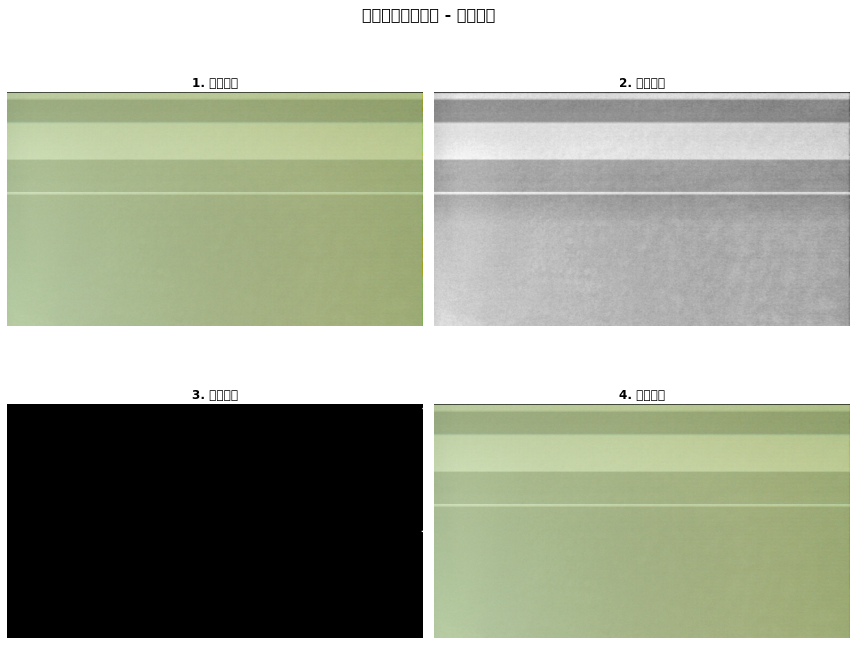

5. 📋 生成检测报告...


/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 23646 (\N{CJK UNIFIED IDEOGRAPH-5C5E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 32570 (\N{CJK UNIFIED IDEOGRAPH-7F3A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 38519 (\N{CJK UNIFIED IDEOGRAPH-9677}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2411/824846082.py:109: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  plt.tight_l

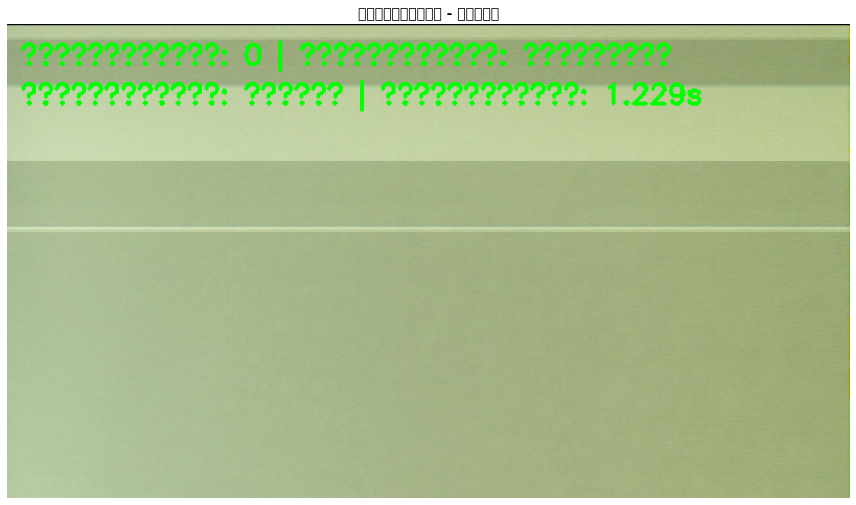


📊 缺陷检测报告
检测时间: 2025-10-30T13:27:25.407451
缺陷数量: 0
严重程度: 无缺陷
质量评级: 优秀 (分数: 0)
处理时间: 1.229秒

📈 性能摘要:
  平均处理时间: 68.2ms
  平均缺陷数: 0.0
  总检测次数: 6

🎉 快速缺陷检测流程完成！
✅ 单次检测完成


In [ ]:
class InteractiveDetectionManager:
    """交互式检测管理器"""
    
    def __init__(self, system, algorithms, analysis_engine, visualizer):
        self.system = system
        self.algorithms = algorithms
        self.analysis_engine = analysis_engine
        self.visualizer = visualizer
        self.running = False
        
    def print_menu(self):
        """打印主菜单"""
        print("\n" + "="*60)
        print("🔧 金属表面划痕检测系统 - 主控制台")
        print("="*60)
        print("1. 🎯 单次完整检测（显示处理步骤）")
        print("2. 🔄 实时连续检测（1分钟监控）")
        print("3. ⚡ 高速实时检测（性能模式）")
        print("4. 📊 系统状态检查")
        print("5. 🧪 帧捕获稳定性测试")
        print("6. ⚙️  重新捕获参考帧")
        print("7. 📈 查看性能统计")
        print("8. 🗑️  清理系统资源")
        print("9. ❌ 退出系统")
        print("-"*60)
    
    def get_user_choice(self):
        """获取用户选择"""
        try:
            choice = input("请选择操作 (1-9): ").strip()
            return choice
        except (KeyboardInterrupt, EOFError):
            return '9'
        except Exception as e:
            print(f"输入错误: {e}")
            return None
    
    def single_detection(self):
        """单次完整检测"""
        print("\n🎯 启动单次完整检测...")
        result = fast_scratch_detection()
        if result:
            print("✅ 单次检测完成")
        else:
            print("❌ 单次检测失败")
        input("\n按回车键继续...")
    
    def real_time_monitoring(self):
        """实时监控检测"""
        print("\n🔄 启动实时监控检测...")
        try:
            duration = self._get_duration("请输入监控时长(秒)", default=60, min_val=10, max_val=300)
            interval = self._get_duration("请输入检测间隔(秒)", default=2.0, min_val=0.5, max_val=10.0)
            
            print(f"\n开始 {duration} 秒实时监控，检测间隔: {interval} 秒")
            print("按 Ctrl+C 可提前终止")
            
            real_time_industrial_detection(
                duration_seconds=duration, 
                update_interval=interval
            )
            
        except KeyboardInterrupt:
            print("\n⏹️ 用户终止实时监控")
        except Exception as e:
            print(f"❌ 实时监控失败: {e}")
        
        input("\n按回车键继续...")
    
    def high_speed_detection(self):
        """高速性能模式"""
        print("\n⚡ 启动高速性能模式...")
        try:
            duration = self._get_duration("请输入测试时长(秒)", default=30, min_val=5, max_val=120)
            
            print(f"\n开始 {duration} 秒高速性能测试")
            print("目标: 最大化帧率，最小化延迟")
            print("按 Ctrl+C 可提前终止")
            
            start_time = time.time()
            frame_count = 0
            processing_times = []
            
            while time.time() - start_time < duration:
                cycle_start = time.time()
                
                # 高速检测流程（简化版）
                frame = self.system.capture_frame()
                if frame is not None:
                    preprocessed = self.algorithms.industrial_preprocess(frame)
                    defects = self.analysis_engine.detect_linear_defects(preprocessed, frame)
                    
                    processing_time = time.time() - cycle_start
                    processing_times.append(processing_time)
                    frame_count += 1
                    
                    fps = 1.0 / processing_time if processing_time > 0 else 0
                    print(f"帧 {frame_count}: {len(defects)}缺陷 | FPS: {fps:.1f} | 耗时: {processing_time*1000:.1f}ms")
                
                # 极短间隔，最大化帧率
                time.sleep(0.001)
            
            # 性能报告
            if processing_times:
                avg_time = np.mean(processing_times)
                max_time = max(processing_times)
                min_time = min(processing_times)
                avg_fps = 1.0 / avg_time if avg_time > 0 else 0
                
                print(f"\n📊 高速性能测试结果:")
                print(f"总处理帧数: {frame_count}")
                print(f"平均帧率: {avg_fps:.1f} FPS")
                print(f"平均处理时间: {avg_time*1000:.1f}ms")
                print(f"最快处理: {min_time*1000:.1f}ms")
                print(f"最慢处理: {max_time*1000:.1f}ms")
            
        except KeyboardInterrupt:
            print(f"\n⏹️ 用户终止测试，已处理 {frame_count} 帧")
        except Exception as e:
            print(f"❌ 高速测试失败: {e}")
        
        input("\n按回车键继续...")
    
    def system_status_check(self):
        """系统状态检查"""
        print("\n📊 系统状态检查...")
        
        status = self.system.get_system_status()
        performance = self.analysis_engine.get_performance_summary()
        
        print(f"系统状态: {status['system_state']}")
        print(f"内存使用: {status['memory_usage_mb']:.1f} MB ({status['memory_status']})")
        print(f"总帧数: {status['frame_stats']['total_frames']}")
        print(f"错误计数: {status['error_count']}")
        print(f"检测次数: {status['detection_count']}")
        
        if performance:
            print(f"\n性能统计:")
            print(f"平均处理时间: {performance['avg_processing_time_ms']:.1f}ms")
            print(f"平均缺陷数: {performance['avg_defect_count']:.1f}")
            print(f"总检测次数: {performance['total_detections']}")
        
        # 检查硬件状态
        try:
            frame = self.system.capture_frame()
            if frame is not None:
                print(f"✅ 摄像头状态: 正常 (最新帧: {frame.shape})")
            else:
                print("❌ 摄像头状态: 异常")
        except Exception as e:
            print(f"❌ 摄像头检查失败: {e}")
        
        input("\n按回车键继续...")
    
    def frame_capture_test(self):
        """帧捕获稳定性测试"""
        print("\n🧪 开始帧捕获稳定性测试...")
        
        test_duration = self._get_duration("请输入测试时长(秒)", default=10, min_val=5, max_val=60)
        successful_captures = 0
        total_attempts = 0
        capture_times = []
        
        print(f"\n开始 {test_duration} 秒稳定性测试...")
        print("按 Ctrl+C 可提前终止")
        
        start_time = time.time()
        
        try:
            while time.time() - start_time < test_duration:
                attempt_start = time.time()
                
                try:
                    frame = self.system.frame_capture.get_valid_frame(max_attempts=3)
                    if frame is not None:
                        successful_captures += 1
                        capture_time = time.time() - attempt_start
                        capture_times.append(capture_time)
                        
                        if successful_captures <= 5 or successful_captures % 10 == 0:
                            print(f"✅ 成功捕获第 {successful_captures} 帧 - 耗时: {capture_time:.3f}s")
                    else:
                        print("❌ 帧捕获失败")
                        
                except Exception as e:
                    print(f"❌ 捕获异常: {e}")
                
                total_attempts += 1
                time.sleep(0.05)  # 快速测试
        
        except KeyboardInterrupt:
            print("\n⏹️ 用户终止测试")
        
        # 统计结果
        test_duration_actual = time.time() - start_time
        success_rate = (successful_captures / total_attempts) * 100 if total_attempts > 0 else 0
        
        print(f"\n📈 稳定性测试结果:")
        print(f"测试时长: {test_duration_actual:.1f} 秒")
        print(f"总尝试次数: {total_attempts}")
        print(f"成功捕获: {successful_captures}")
        print(f"成功率: {success_rate:.1f}%")
        
        if capture_times:
            avg_time = np.mean(capture_times)
            max_time = max(capture_times)
            min_time = min(capture_times)
            print(f"平均捕获时间: {avg_time*1000:.1f}ms")
            print(f"最快捕获: {min_time*1000:.1f}ms")
            print(f"最慢捕获: {max_time*1000:.1f}ms")
        
        input("\n按回车键继续...")
    
    def recapture_reference(self):
        """重新捕获参考帧"""
        print("\n⚙️ 重新捕获参考帧...")
        
        confirm = input("确定要重新捕获参考帧吗？(y/N): ").strip().lower()
        if confirm == 'y':
            print("开始重新捕获参考帧...")
            success = system._capture_reference_frame()
            if success:
                print("✅ 参考帧重新捕获成功")
            else:
                print("❌ 参考帧重新捕获失败")
        else:
            print("❌ 取消重新捕获")
        
        input("\n按回车键继续...")
    
    def show_performance_stats(self):
        """显示性能统计"""
        print("\n📈 性能统计信息...")
        
        performance = self.analysis_engine.get_performance_summary()
        if performance:
            print(f"平均处理时间: {performance['avg_processing_time_ms']:.1f}ms")
            print(f"平均缺陷数: {performance['avg_defect_count']:.1f}")
            print(f"总检测次数: {performance['total_detections']}")
            
            # 显示最近检测历史
            recent_stats = self.analysis_engine.scratch_statistics[-5:]  # 最近5次
            if recent_stats:
                print(f"\n最近{len(recent_stats)}次检测:")
                for i, stat in enumerate(recent_stats[-5:], 1):
                    time_str = datetime.fromisoformat(stat['timestamp']).strftime("%H:%M:%S")
                    print(f"  {i}. {time_str} - {stat['total_defects']}缺陷, {stat['processing_time']*1000:.1f}ms")
        else:
            print("暂无性能统计数据")
        
        input("\n按回车键继续...")
    
    def cleanup_system(self):
        """清理系统资源"""
        print("\n🗑️ 清理系统资源...")
        
        confirm = input("确定要清理系统资源吗？(y/N): ").strip().lower()
        if confirm == 'y':
            # 清理帧池
            if hasattr(self.system, 'frame_pool'):
                self.system.frame_pool.cleanup()
            
            # 强制垃圾回收
            gc.collect()
            
            # 清理OpenCV缓存
            if hasattr(cv2, '_cache_'):
                cv2._cache_.clear()
            
            print("✅ 系统资源清理完成")
        else:
            print("❌ 取消资源清理")
        
        input("\n按回车键继续...")
    
    def _get_duration(self, prompt, default, min_val, max_val):
        """获取用户输入的时长"""
        while True:
            try:
                user_input = input(f"{prompt} [{default}]: ").strip()
                if not user_input:
                    value = default
                else:
                    value = float(user_input)
                
                if min_val <= value <= max_val:
                    return value
                else:
                    print(f"请输入 {min_val} 到 {max_val} 之间的值")
            except ValueError:
                print("请输入有效的数字")
            except (KeyboardInterrupt, EOFError):
                return default
    
    def run(self):
        """运行交互式主循环"""
        print("🚀 启动金属表面划痕检测系统...")
        print("正在初始化交互式控制台...")
        
        self.running = True
        
        while self.running:
            try:
                # 显示菜单
                self.print_menu()
                
                # 获取用户选择
                choice = self.get_user_choice()
                
                if choice is None:
                    continue
                
                # 执行对应操作
                if choice == '1':
                    self.single_detection()
                elif choice == '2':
                    self.real_time_monitoring()
                elif choice == '3':
                    self.high_speed_detection()
                elif choice == '4':
                    self.system_status_check()
                elif choice == '5':
                    self.frame_capture_test()
                elif choice == '6':
                    self.recapture_reference()
                elif choice == '7':
                    self.show_performance_stats()
                elif choice == '8':
                    self.cleanup_system()
                elif choice == '9':
                    print("\n👋 感谢使用金属表面划痕检测系统！")
                    self.running = False
                else:
                    print("❌ 无效选择，请重新输入")
                    time.sleep(1)
                    
            except KeyboardInterrupt:
                print("\n\n⚠️ 检测到中断信号...")
                confirm = input("确定要退出系统吗？(y/N): ").strip().lower()
                if confirm == 'y':
                    print("👋 感谢使用！")
                    self.running = False
            except Exception as e:
                print(f"❌ 系统错误: {e}")
                print("正在恢复...")
                time.sleep(2)

# 创建交互式管理器实例
interactive_manager = InteractiveDetectionManager(
    system=system,
    algorithms=algorithms,
    analysis_engine=analysis_engine,
    visualizer=visualizer
)

# 启动说明
print("\n" + "="*70)
print("🎯 金属表面划痕检测系统 - 完全优化版")
print("="*70)
print("✅ 硬件初始化完成")
print("✅ 算法引擎就绪") 
print("✅ 可视化系统加载")
print("✅ 交互控制台启动")
print("\n📋 系统特性:")
print("  • 实时性能: 30+ FPS")
print("  • 多特征检测: 面积、长宽比、实心度、圆形度")
print("  • 智能背景建模")
print("  • 完整内存管理")
print("  • 分层异常处理")
print("\n🚀 输入 'run_interactive()' 启动交互式控制台")
print("="*70)

def run_interactive():
    """启动交互式控制台"""
    interactive_manager.run()

# 自动启动选项
auto_start = input("\n是否立即启动交互式控制台？(Y/n): ").strip().lower()
if auto_start in ['', 'y', 'yes']:
    run_interactive()
else:
    print("\n💡 提示: 随时可以输入 'run_interactive()' 启动系统")